no negative sampling  

NN_word = 200  
num_features = 3

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.
/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import lowcols

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 200
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
a
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)

cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

28


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 200)


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 200)


c1  c2  c3  c4  c5  c6  c7  c8  c9  c10  ...   c191  c192  c193  c194  \
r1   0   1   1   0   1   0   1   0   1    1  ...      0     0     0     0   
r2   0   0   1   1   1   0   0   0   0    1  ...      0     0     0     0   
r3   1   1   1   0   0   0   1   0   1    0  ...      0     0     0     0   
r4   0   0   0   0   0   0   0   0   0    0  ...      0     0     0     0   
r5   0   0   1   0   1   0   1   1   0    0  ...      0     0     0     0   

    c195  c196  c197  c198  c199  c200  
r1     0     0     0     0     0     0  
r2     0     0     0     0     0     0  
r3     0     0     0     0     0     0  
r4     0     0     0     0     0     0  
r5     0     0     0     0     0     0  

[5 rows x 200 columns]

In [11]:
X_df.values.shape

(10000, 200)

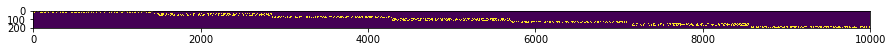

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(X_df.values.T)

In [13]:
from collections.abc import Sequence

class DocSeq(Sequence):
    '''
    doc_dic  : doc_name (unique)
    word_dic : coding (index=0) is not necessary
    '''
    def __init__(self, df):
        self.df = df
        self.cols = self.df.columns.values
        
        self.doc_dic = gensim.corpora.Dictionary([df.index.values.tolist()], prune_at=None)
        self.word_dic = gensim.corpora.Dictionary([list(self.cols)], prune_at=None)
        
    def __getitem__(self, idx):
        return self._get(idx)
    
    def _get(self, idx):
        try:
            ebid = self.doc_dic[idx]
        except KeyError:
            raise IndexError
        irow = self.df.loc[ebid]
        res = []
        for icol in self.cols:
            if irow[icol] == 1:
                res.append(icol)
        return res
    
    def __len__(self):
        return self.df.shape[0]

In [14]:
doc_seq = DocSeq(X_df)
len(doc_seq)

10000

In [15]:
len(doc_seq.doc_dic)

10000

In [16]:
wd2v = lowcols.WD2vec_low(doc_seq)
wd2v

In [17]:
num_features = 3

models = wd2v.make_model(num_user=len(doc_seq.doc_dic), num_product=NN_word, num_features=num_features)
models['model_gk1'].summary()
models['model_user'].summary()
print('\n\n##################### model >>>')
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 3)              30000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 200)               601       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_e

In [18]:
wd2v.models['model'].get_layer('user_embedding').get_weights()[0].shape

(10000, 3)

(10000, 3)


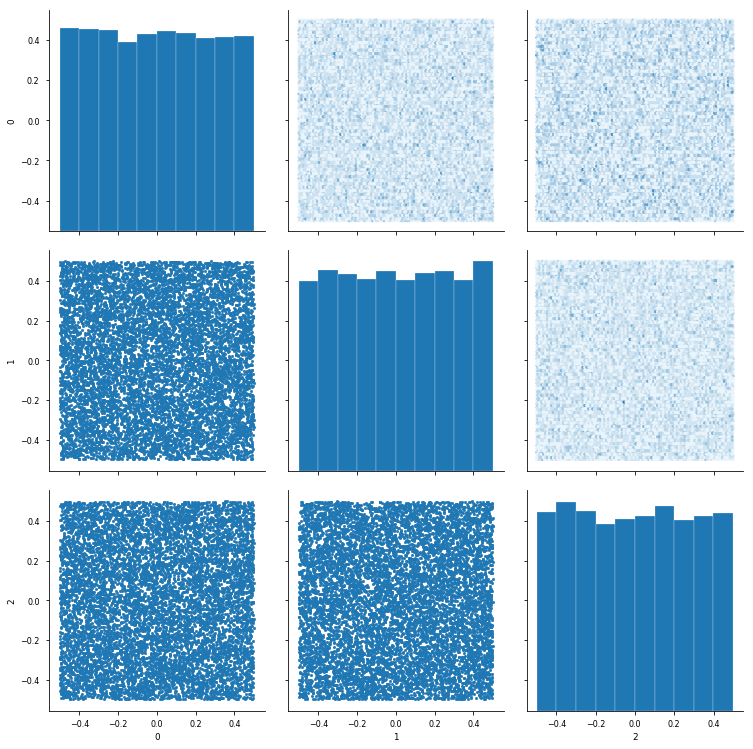

In [19]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
# wgt_user = model.get_layer('user_embedding').get_weights()[0]
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


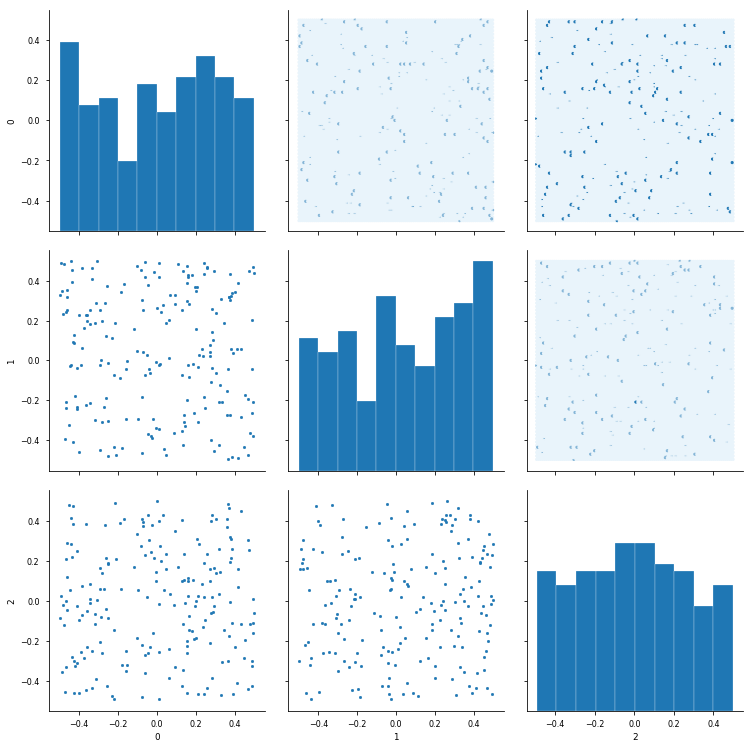

In [20]:
wgt_lm = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_lm.shape)
df = pd.DataFrame(wgt_lm[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

### 1

In [21]:
wd2v.train(epochs=30, batch_size=32, verbose=2)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
14s - loss: 0.5980 - acc: 0.7090
Epoch 2/30
14s - loss: 0.3570 - acc: 0.8778
Epoch 3/30
13s - loss: 0.3137 - acc: 0.9165
Epoch 4/30
14s - loss: 0.3014 - acc: 0.9266
Epoch 5/30
14s - loss: 0.2926 - acc: 0.9309
Epoch 6/30
14s - loss: 0.2850 - acc: 0.9335
Epoch 7/30
14s - loss: 0.2786 - acc: 0.9353
Epoch 8/30
14s - loss: 0.2730 - acc: 0.9364
Epoch 9/30
14s - loss: 0.2682 - acc: 0.9371
Epoch 10/30
14s - loss: 0.2640 - acc: 0.9374
Epoch 11/30
13s - loss: 0.2602 - acc: 0.9376
Epoch 12/30
14s - loss: 0.2569 - acc: 0.9377
Epoch 13/30
13s - loss: 0.2539 - acc: 0.9377
Epoch 14/30
13s - loss: 0.2512 - acc: 0.9377
Epoch 15/30
14s - loss: 0.2488 - acc: 0.9377
Epoch 16/30
14s - loss: 0.2465 - acc: 0.9377
Epoch 17/30
14s - loss: 0.2444 - acc: 0.9377
Epoch 18/30
14s - loss: 0.2425 - acc: 0.9377
Epoch 19/30
13s - loss: 0.2406 - acc: 0.9377
Epoch 20/30
13s - loss: 0.2389 - acc: 0.9377
Epoch 21/30
14s - loss: 0.2372 - acc: 0.9377
Epoch 22/30
14s - loss: 0.2355 - acc: 0.9377
Epoch 23/30
14s - l

(200, 3)


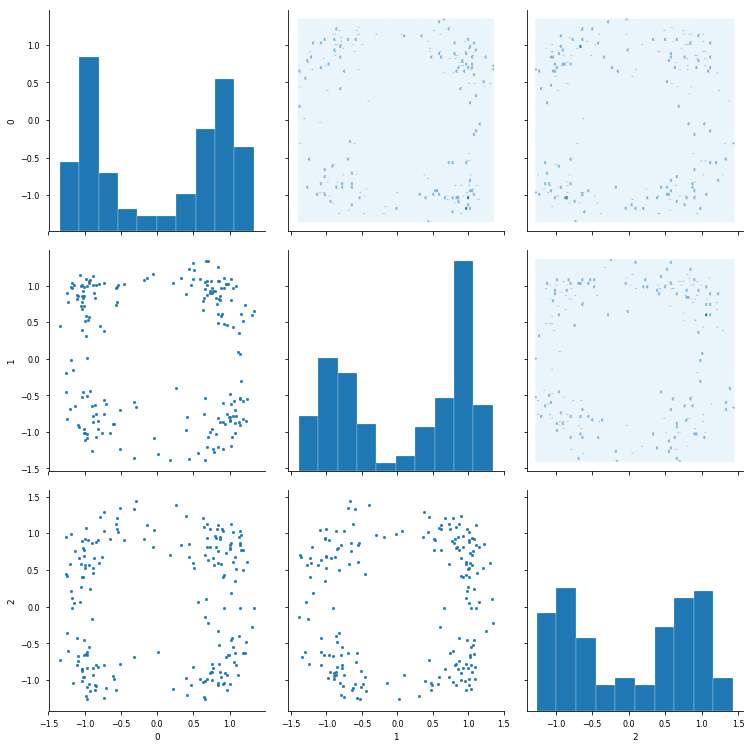

In [22]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


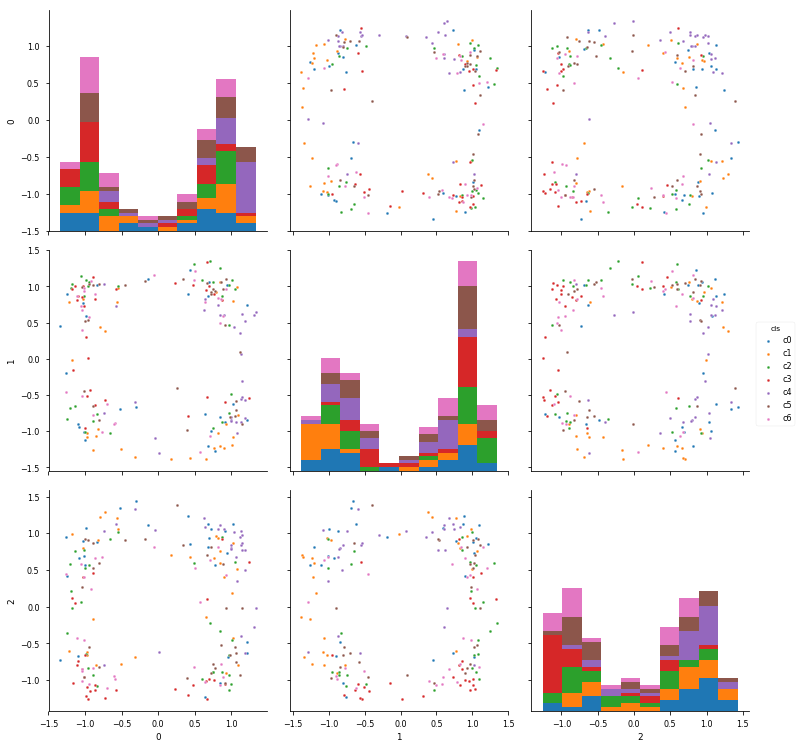

In [23]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


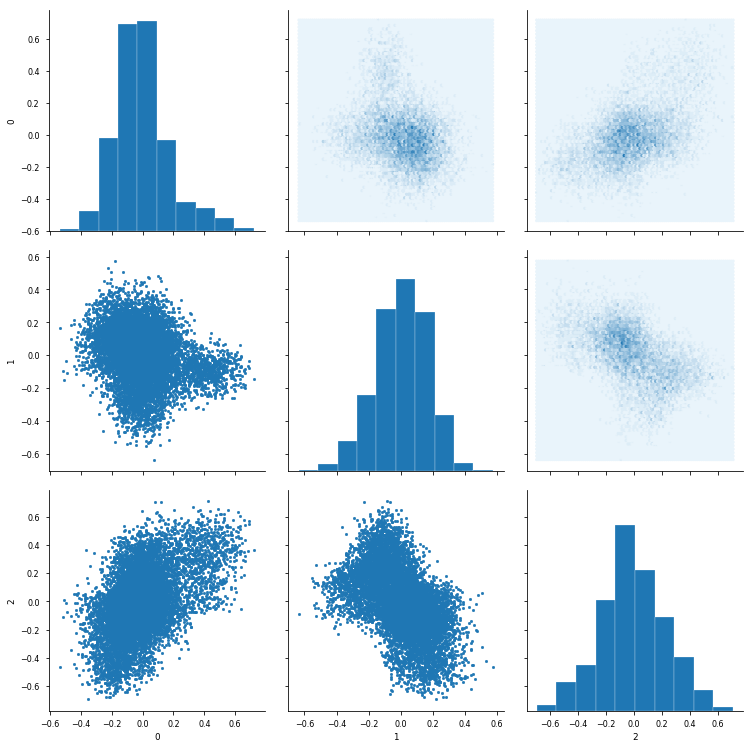

In [24]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


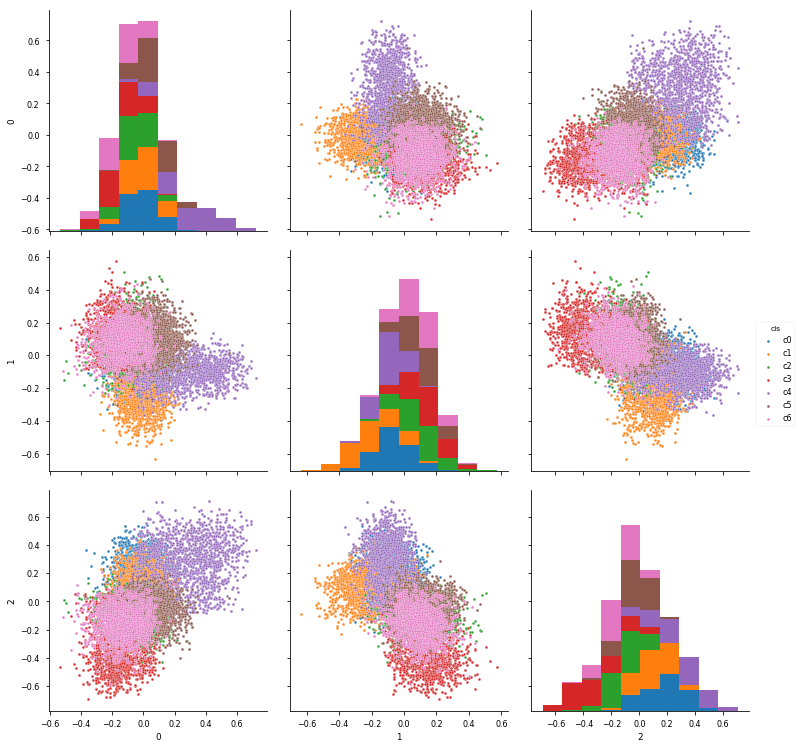

In [25]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [26]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [28]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -0.596860  0.423382  c0
1 -0.065560  0.407435  c0
2  0.664057 -1.072985  c0
3  1.318886  0.301368  c0
4  0.828798 -0.708750  c0

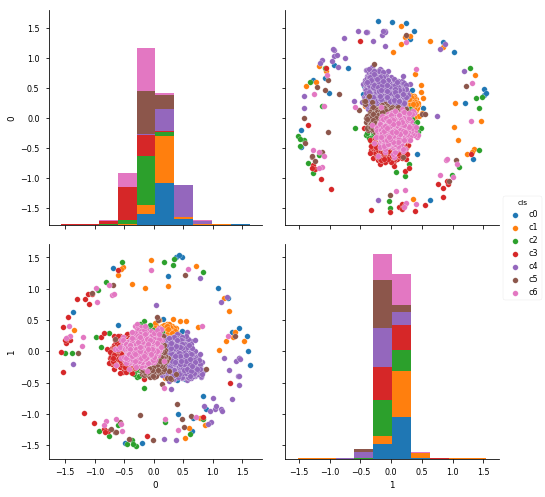

In [29]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [30]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [31]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  23.014116 -85.618111  c0
1  24.056749 -84.456802  c0
2  32.138241 -80.656525  c0
3  58.735142 -62.142216  c0
4  31.761715 -81.519760  c0

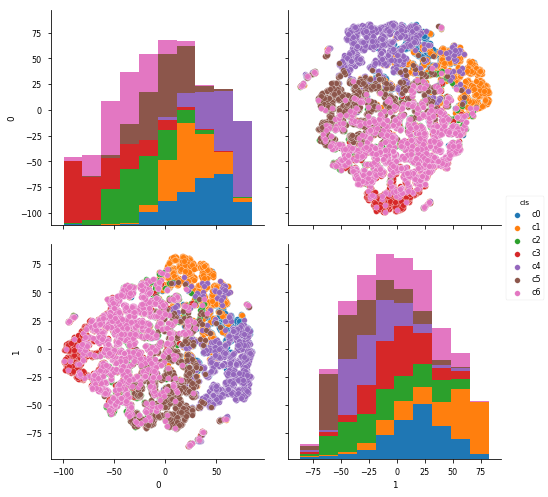

In [32]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 2 (further train)

In [33]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 3)


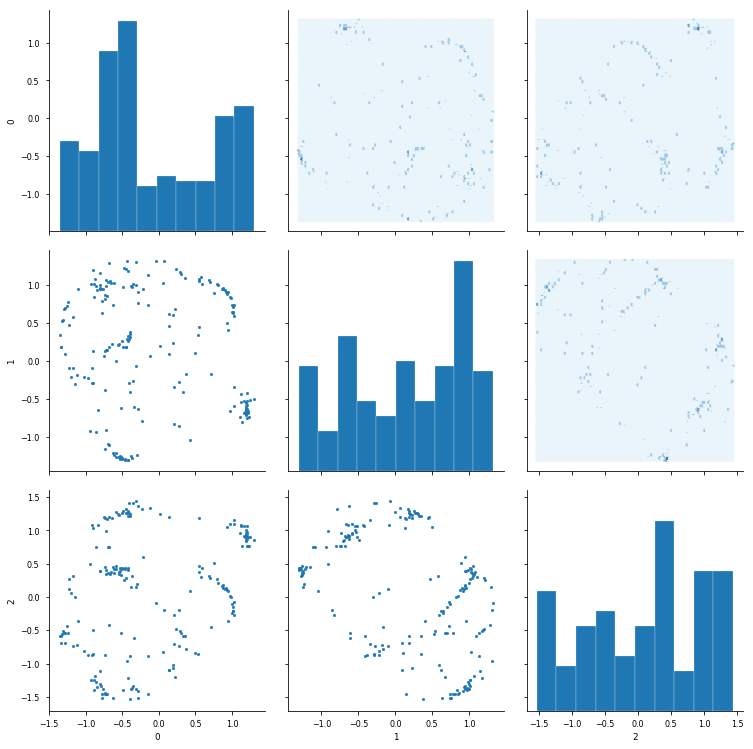

In [34]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


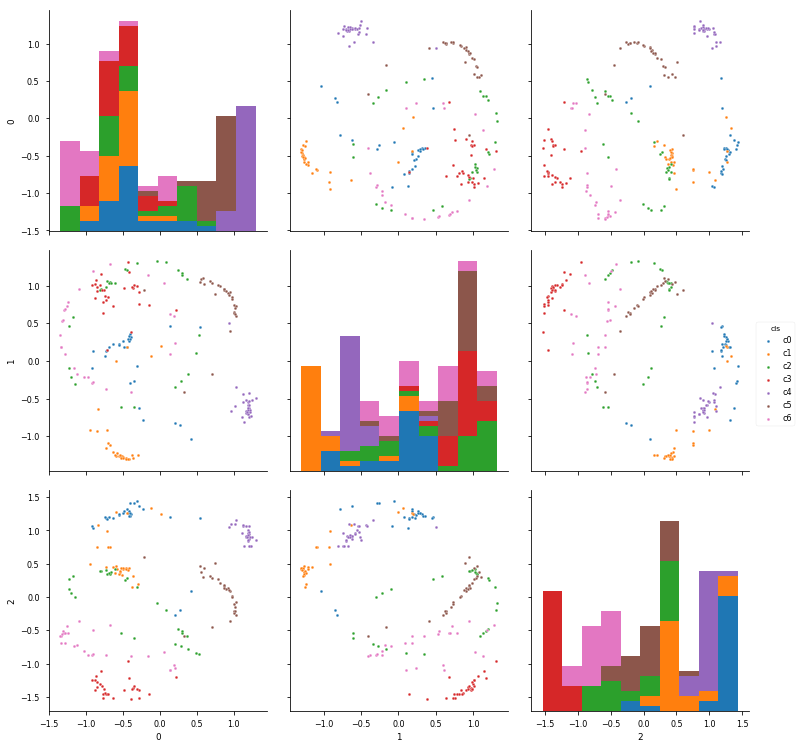

In [35]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


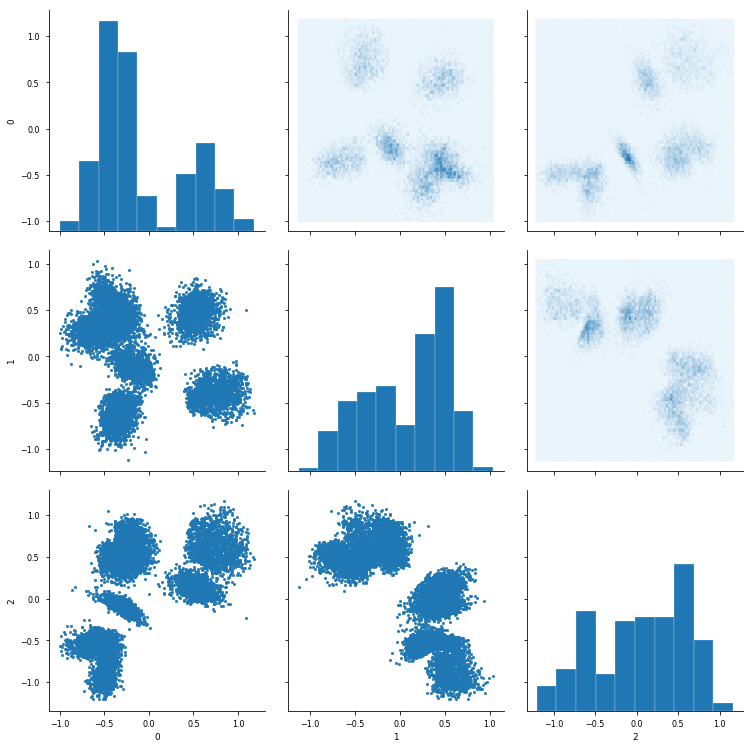

In [36]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


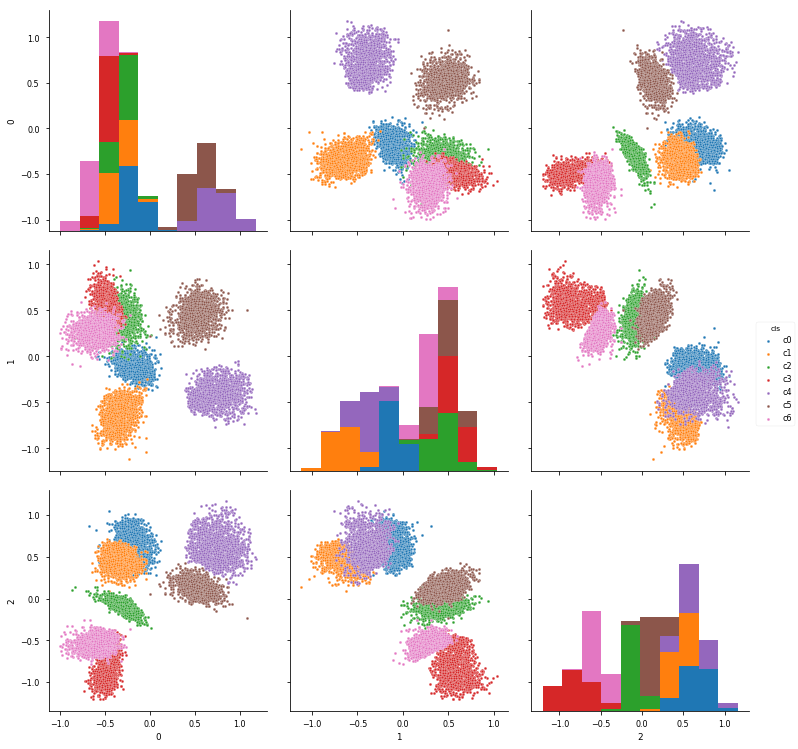

In [37]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [38]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [40]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -0.497043  0.516010  c0
1 -0.574248  0.450540  c0
2 -0.614022  0.277603  c0
3 -1.283627  0.785064  c0
4 -0.653576  0.336332  c0

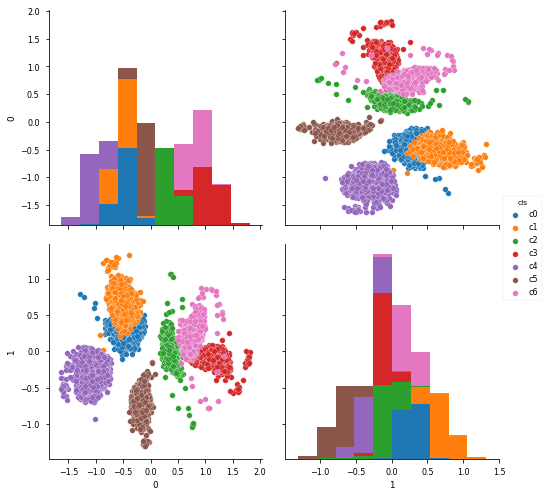

In [41]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [42]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [43]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0 -77.775848  13.283724  c0
1 -78.207359  13.255365  c0
2 -78.889923  13.163551  c0
3 -73.433861  39.481350  c0
4 -78.767090  13.259459  c0

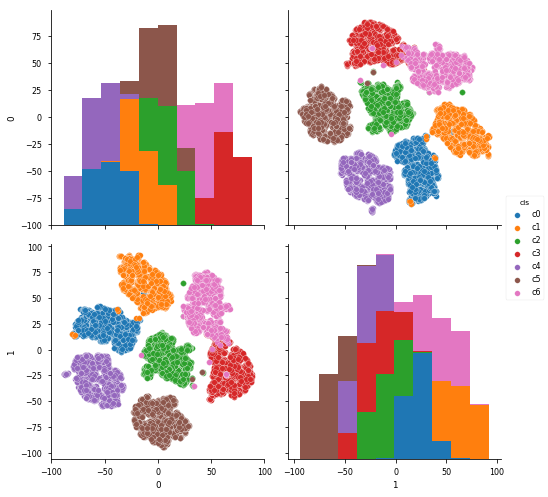

In [44]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 3 (further train)

In [45]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 3)


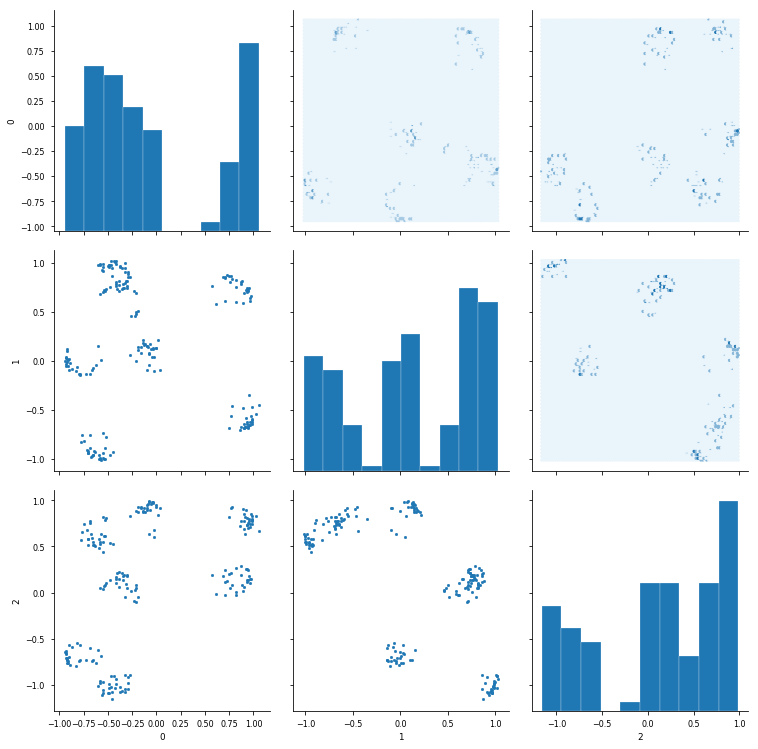

In [46]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


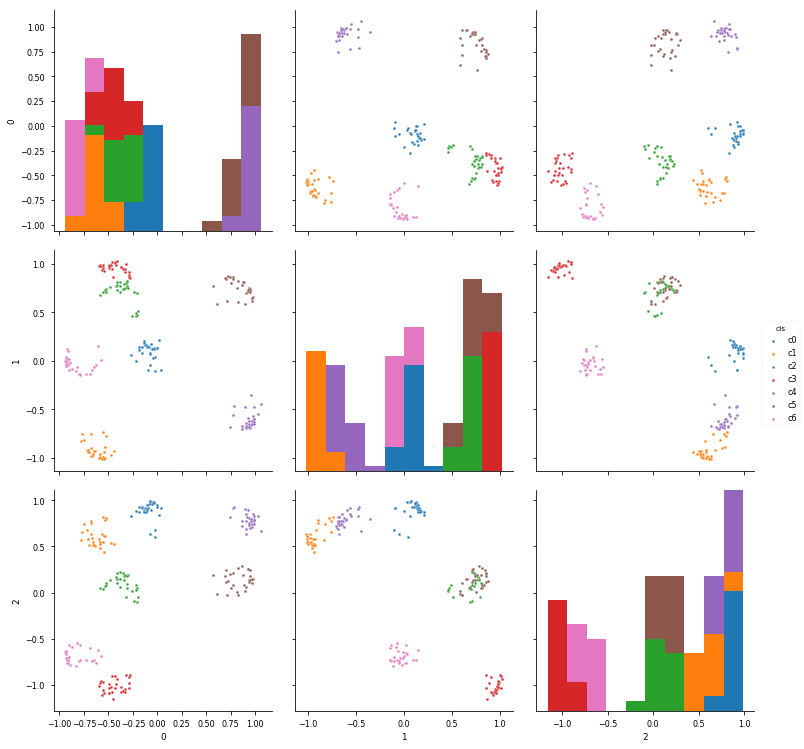

In [47]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


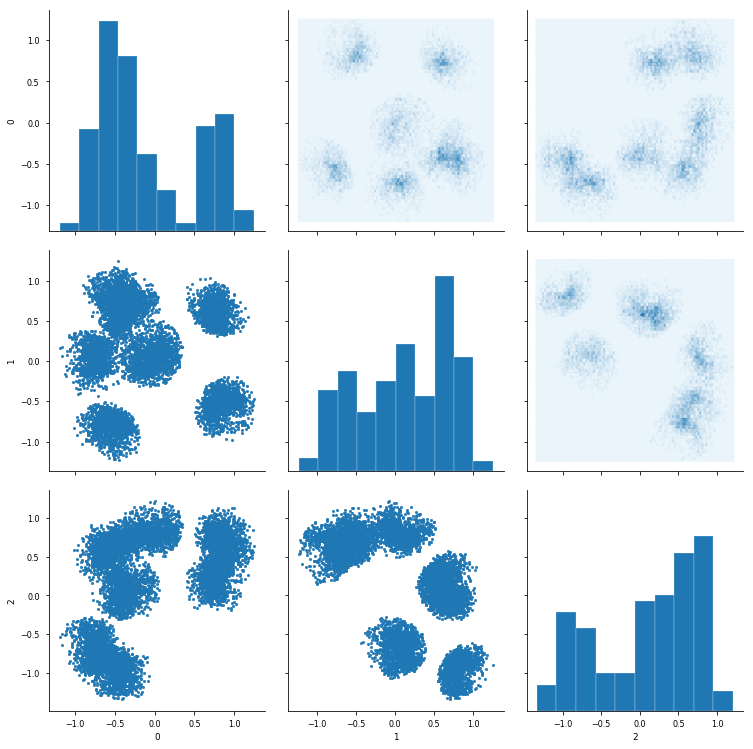

In [48]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


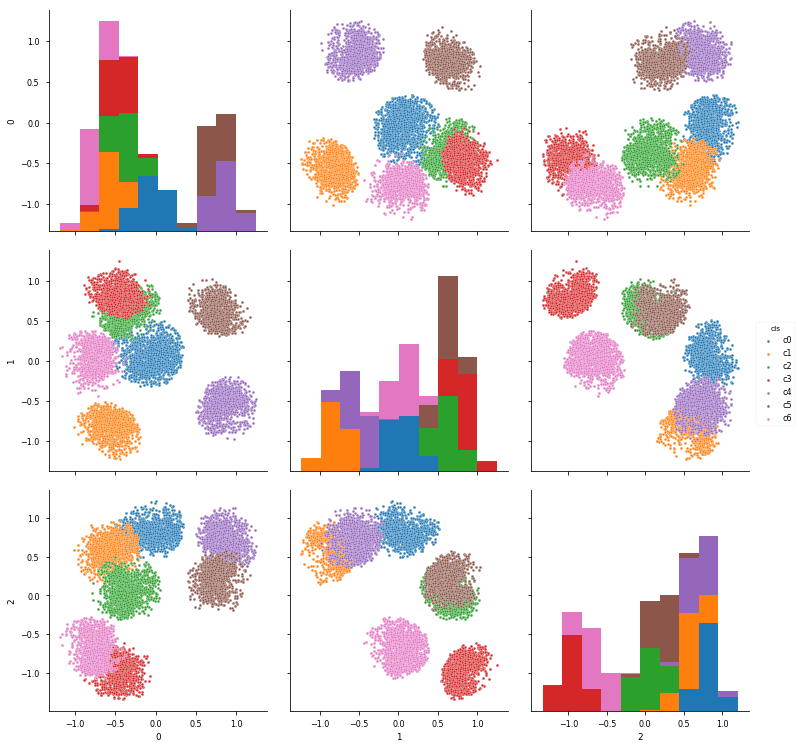

In [49]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [50]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [52]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -0.520073  0.037663  c0
1 -0.500684  0.019031  c0
2 -0.640300 -0.031744  c0
3 -0.700611  0.191650  c0
4 -0.663564 -0.001302  c0

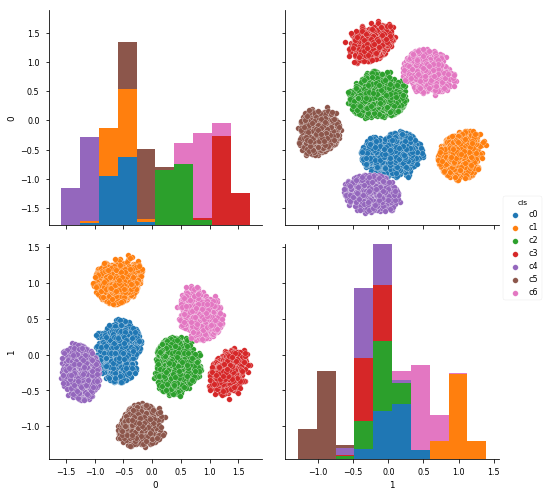

In [53]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [54]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [55]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  -7.897563  14.908428  c0
1  -7.528265  14.916821  c0
2  -9.103018  12.630738  c0
3 -40.409336  17.868015  c0
4  -9.326126  12.963245  c0

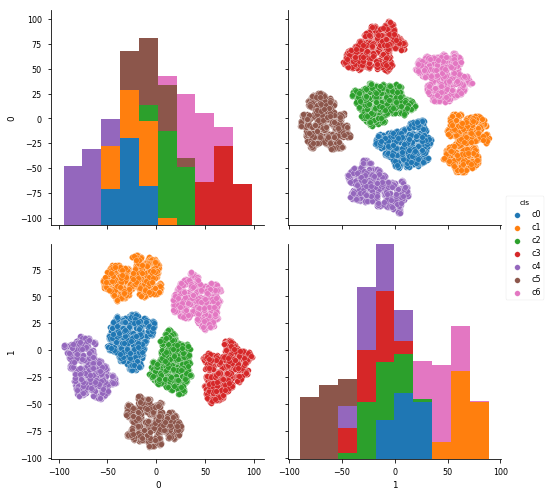

In [56]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 4 (further train)

In [57]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 3)


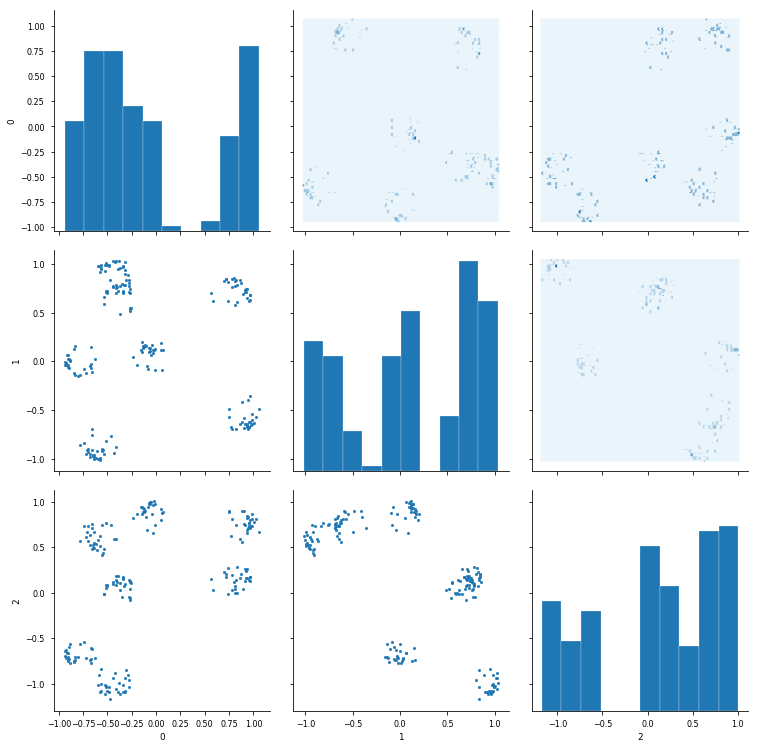

In [58]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


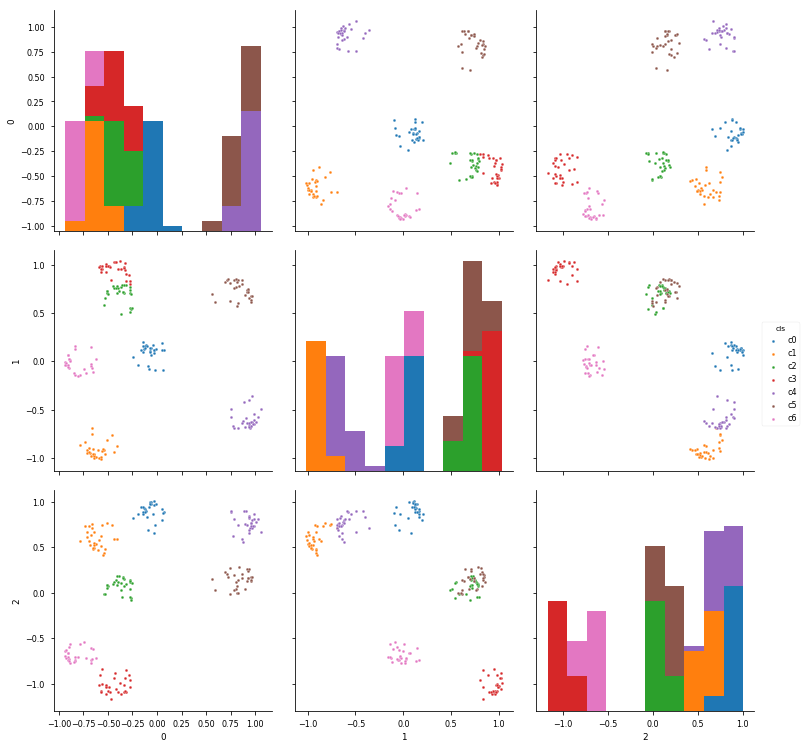

In [59]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


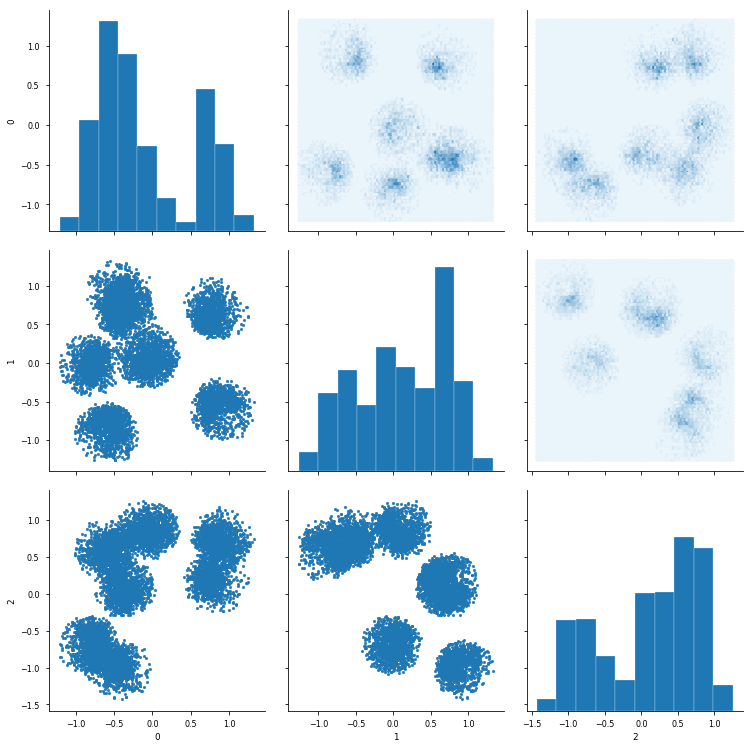

In [60]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


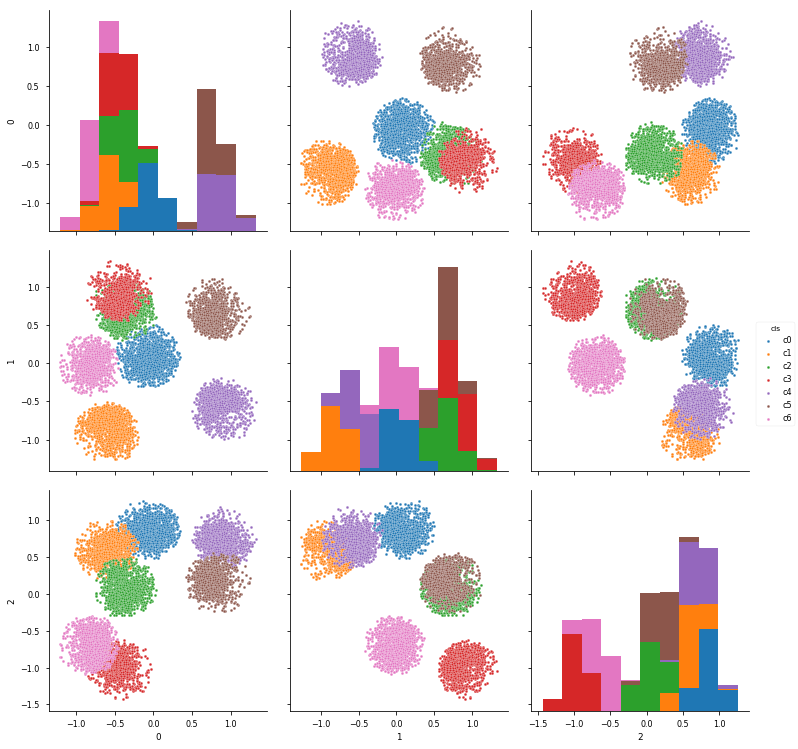

In [61]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [62]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [63]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [64]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -0.567895  0.022204  c0
1 -0.498821  0.008265  c0
2 -0.646673 -0.099082  c0
3 -0.716425  0.150493  c0
4 -0.692860 -0.017452  c0

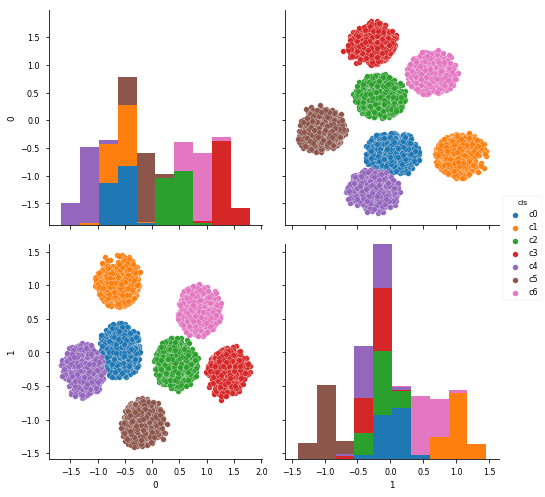

In [65]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [66]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [67]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  -7.561700  12.169469  c0
1  -8.915112  11.587234  c0
2 -30.697680   0.611148  c0
3 -40.527252  26.170044  c0
4  -4.069343  12.672325  c0

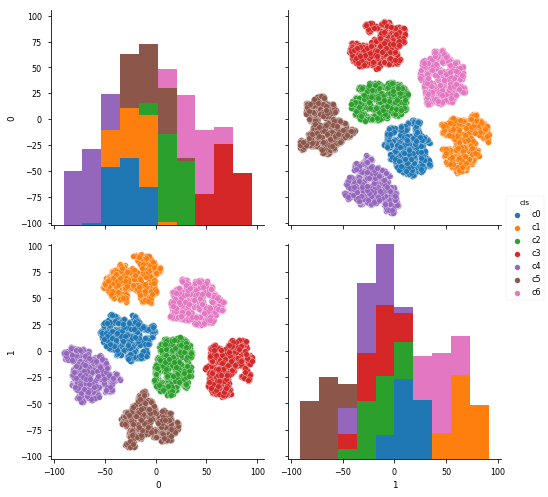

In [68]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 5 (further train)

In [69]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 3)


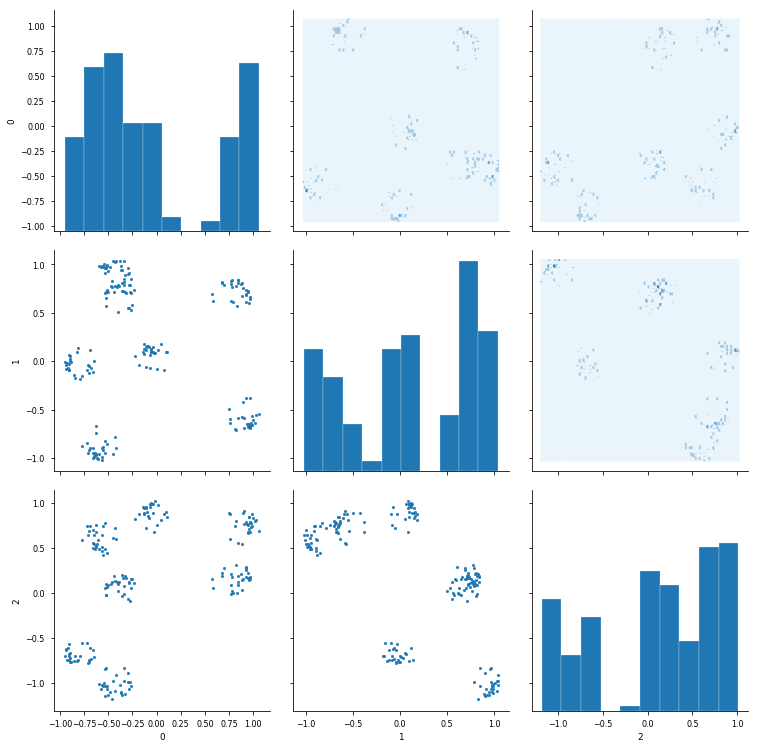

In [70]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


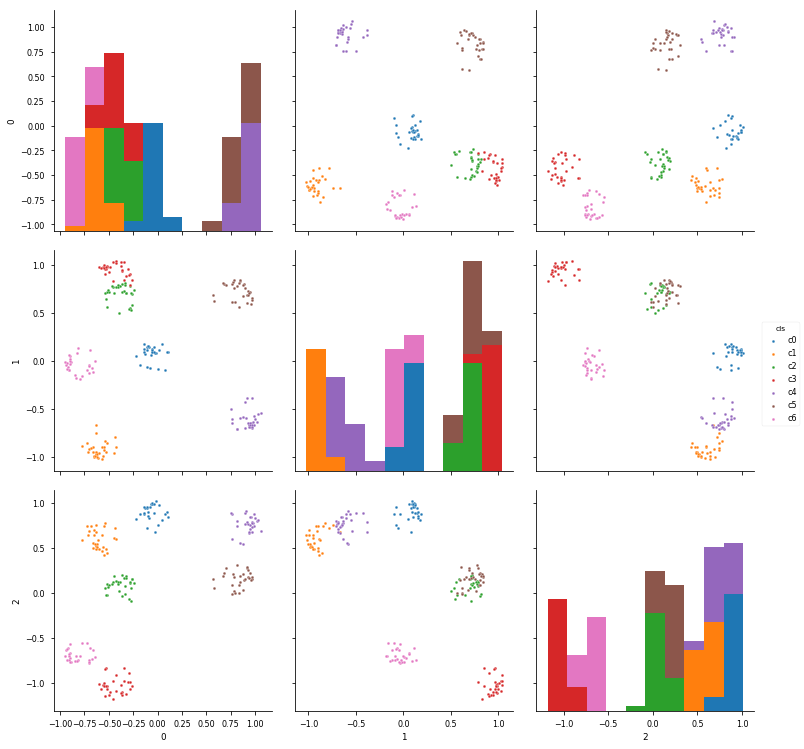

In [71]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


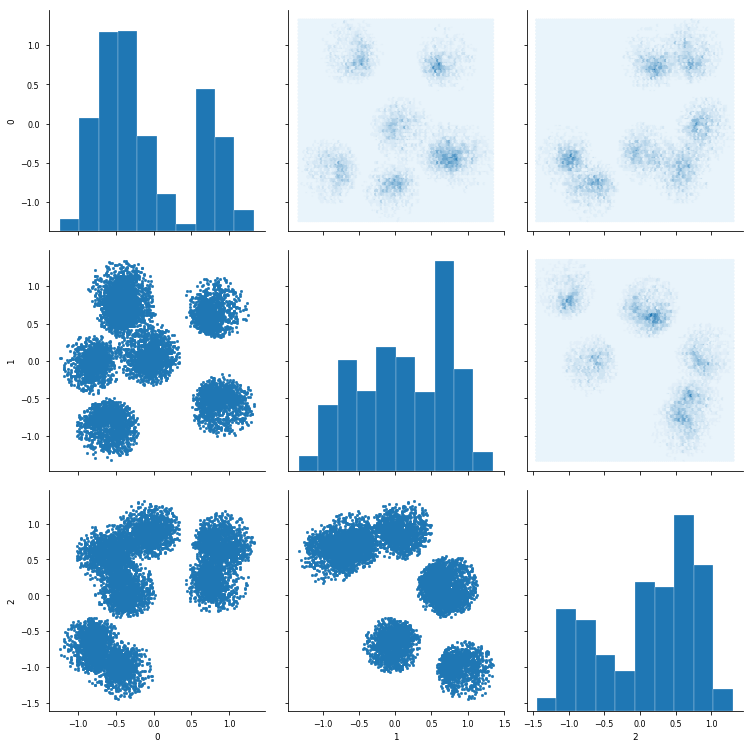

In [72]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


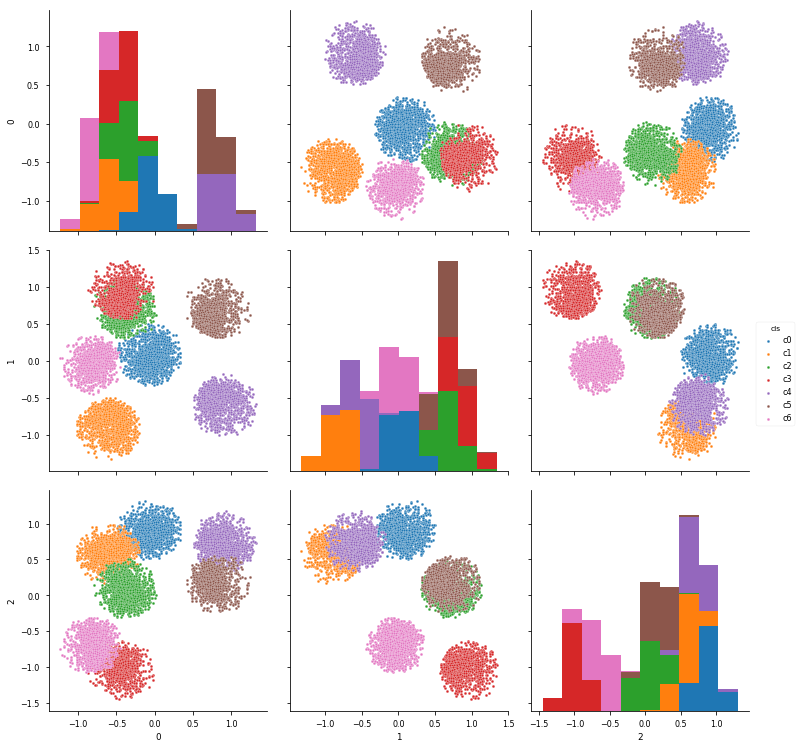

In [73]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [74]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [76]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -0.588320  0.008646  c0
1 -0.512746  0.005870  c0
2 -0.636915 -0.125276  c0
3 -0.730352  0.125314  c0
4 -0.716987 -0.022891  c0

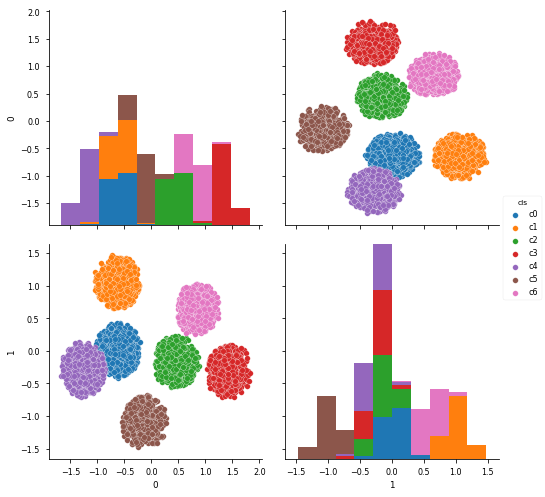

In [77]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [78]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [79]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0 -12.613043  21.130529  c0
1  -6.180984   3.682987  c0
2 -33.048210   4.978776  c0
3 -41.811565  22.481054  c0
4 -28.137035 -15.739778  c0

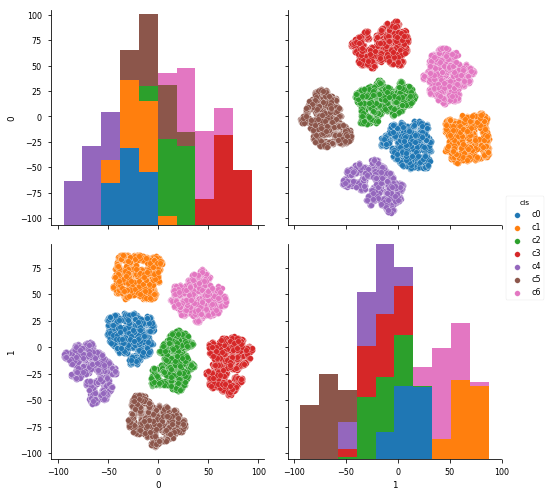

In [80]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')